#### Test Configuration

In [1]:
base_model = "ntu-spml/distilhubert"
test_model = "SemanticVAD(2_2000).pt"
NUM_LABELS = 2
device = "cpu"
test_data = "./dataset/binary_classification/test/test.csv"
round = 50

#### Load Model

⚠️ Notice: change the corresponding parameters in the constructor of 'DistilHuBERTClassifier' of train.py to match the testing model.

In [2]:
import torch
from transformers import AutoModel
from train import DistilHuBERTClassifier
encoder = AutoModel.from_pretrained(base_model)
model = DistilHuBERTClassifier(base_model=encoder, num_labels=NUM_LABELS)
model.load_state_dict(torch.load(test_model, map_location=device))
model.eval()

DistilHuBERTClassifier(
  (encoder): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(
       

#### Memory/Time Test For Mac (CPU/GPU Uniform)

In [3]:
import pandas as pd
import time
df = pd.read_csv(test_data).sample(n=round, random_state=int(time.time()))



In [4]:
import torch
import torchaudio
import time
from transformers import AutoFeatureExtractor
import psutil
import os

extractor = AutoFeatureExtractor.from_pretrained("ntu-spml/distilhubert")
process = psutil.Process(os.getpid())
memory_used = [process.memory_info().rss / 1024 / 1024]
memory_cost = [None]
sum_memory_cost=0
time_cost = [None]
sum_sample_duration = 0
sample_durations=[None]
sum_time=0

for idx, row in df.iterrows():
    file_path = row['filepath']
    waveform, sr = torchaudio.load(file_path)
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)
        sr = 16000

    print(file_path)
    
    inputs = extractor(waveform.squeeze().numpy(), sampling_rate=sr, return_tensors="pt")
    input_values = inputs["input_values"]

    before = process.memory_info().rss
    start = time.time()
    # inference
    with torch.no_grad():
        output = model(input_values=input_values)
    after = process.memory_info().rss
    end = time.time()

    print("_"*40)
    print(f"Memory before reference: {before / 1024 / 1024:.2f} MB")
    print(f"Memory after reference: {after / 1024 / 1024:.2f} MB")
    print(f"Memory cost: {(after-before) / 1024 / 1024:.2f} MB")
    print()
    memory_used.append(before / 1024 / 1024)
    sum_memory_cost += after-before
    memory_cost.append(sum_memory_cost / 1024 / 1024)
    duration_seconds = input_values.shape[-1] / 16000
    print(f"Sample duration: {duration_seconds:.2f} seconds")
    sample_durations.append(duration_seconds)
    sum_sample_duration += duration_seconds
    print(f"Time spent on reference: {end - start}")
    sum_time += end-start
    time_cost.append(end-start)
    print("_"*40)



dataset/binary_classification/test/label1/023258.wav
________________________________________
Memory before reference: 653.42 MB
Memory after reference: 682.47 MB
Memory cost: 29.05 MB

Sample duration: 0.50 seconds
Time spent on reference: 0.017571210861206055
________________________________________
dataset/binary_classification/test/label0/012240.wav
________________________________________
Memory before reference: 682.53 MB
Memory after reference: 694.59 MB
Memory cost: 12.06 MB

Sample duration: 0.50 seconds
Time spent on reference: 0.012562990188598633
________________________________________
dataset/binary_classification/test/label1/017498.wav
________________________________________
Memory before reference: 694.66 MB
Memory after reference: 700.27 MB
Memory cost: 5.61 MB

Sample duration: 0.50 seconds
Time spent on reference: 0.010931253433227539
________________________________________
dataset/binary_classification/test/label0/010097.wav
_______________________________________

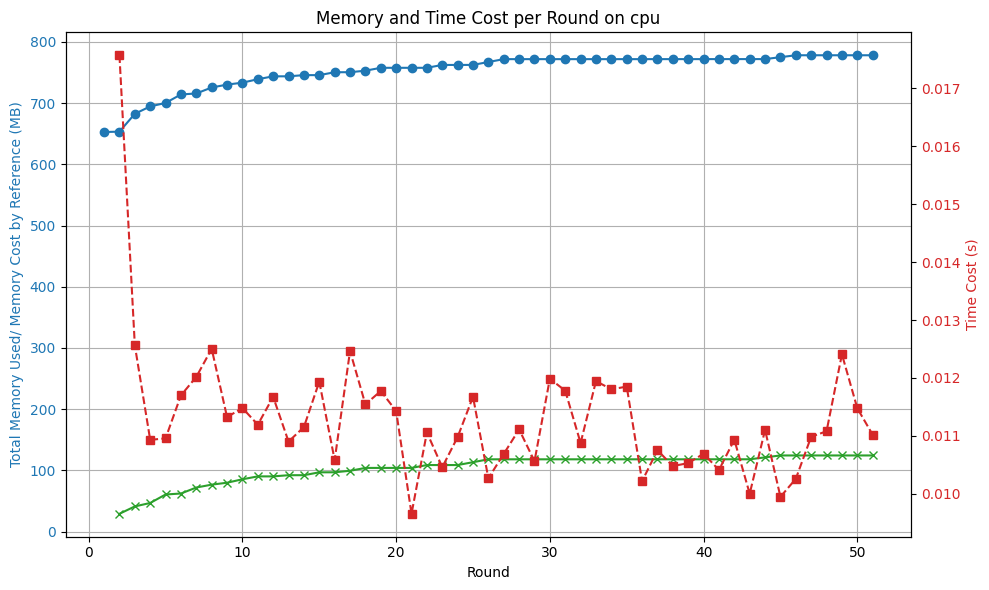

Total memory cost by reference: 124.36 MB
Average input length: 0.500 s
Average time cost: 11.29 ms


In [5]:
import matplotlib.pyplot as plt

rounds = list(range(1, len(memory_used) + 1))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Memory Used
color1 = 'tab:blue'
color2 = 'tab:green'
ax1.set_xlabel('Round')
ax1.set_ylabel('Total Memory Used/ Memory Cost by Reference (MB)', color=color1)
ax1.plot(rounds, memory_used, marker='o', color=color1, label='Total Memory Used')
ax1.plot(rounds, memory_cost, marker="x", color=color2, label='Memory Cost by Reference')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Time Cost
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Time Cost (s)', color=color2)
ax2.plot(rounds, time_cost, marker='s', linestyle='--', color=color2, label='Time Cost')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f'Memory and Time Cost per Round on {device}')
fig.tight_layout()
plt.show()

print(f"Total memory cost by reference: {(sum_memory_cost) / 1024 / 1024:.2f} MB")
print(f"Average input length: {sum_sample_duration/round:.3f} s")
print(f"Average time cost: {(sum_time)/round*1000:.2f} ms")

#### Multi-thread Test

The following is just a script.
Pleas run TEST_Multithread_Memory.py.

In [6]:
import torch
import torchaudio
import concurrent.futures
import psutil
import time
import matplotlib.pyplot as plt
import random
import gc

# ====== Load Model and Feature Extractor ======
from transformers import AutoFeatureExtractor, AutoModel
from train import DistilHuBERTClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = "ntu-spml/distilhubert"
extractor = AutoFeatureExtractor.from_pretrained(base_model)

encoder = AutoModel.from_pretrained(base_model)
NUM_LABELS = 4
model = DistilHuBERTClassifier(base_model=encoder, num_labels=NUM_LABELS)
model.load_state_dict(torch.load(test_model, map_location=device))
model.eval()

process = psutil.Process(os.getpid())

# ====== Prepare dataset ======
file_list = list(df['filepath'])  # Assume your CSV is already loaded
assert len(file_list) > 0, "No audio files found!"

# ====== Define Single Inference Function ======
def single_inference(file_path):
    """
    Perform inference on a single audio file.
    """
    waveform, sr = torchaudio.load(file_path)
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)
    inputs = extractor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
    input_values = inputs["input_values"]

    with torch.no_grad():
        _ = model(input_values=input_values)

# ====== Define Thread Worker Function ======
def thread_worker(thread_id, memory_log, file_list):
    """
    Each thread runs 50 rounds of inference independently and records memory usage after each inference.
    """
    local_memory_log = []
    for round_idx in range(50):  # Each thread performs 50 inferences
        file_path = random.choice(file_list)

        before = process.memory_info().rss / 1024 / 1024  # Memory in MB before inference

        single_inference(file_path)

        after = process.memory_info().rss / 1024 / 1024  # Memory in MB after inference
        used = after - baseline_memory
        local_memory_log.append(used)

        gc.collect()  # Garbage collection to minimize interference

    memory_log[thread_id] = local_memory_log

# ====== Main Experiment Setup ======
thread_counts = [2, 4, 6, 8, 10, 12]
rounds_per_thread = 50

# Measure baseline memory after model loading (before any inference)
baseline_memory = process.memory_info().rss / 1024 / 1024  # In MB
print(f"Baseline memory after loading model: {baseline_memory:.2f} MB")

# Store memory usage results for each thread configuration
all_results = {}

for num_threads in thread_counts:
    print(f"\n🚀 Starting experiment with {num_threads} threads...")

    memory_log = {}

    # Launch multiple threads (each running 50 rounds independently)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(thread_worker, tid, memory_log, file_list) for tid in range(num_threads)]
        concurrent.futures.wait(futures)

    # Average memory usage per round across all threads
    avg_memory_per_round = [0] * rounds_per_thread
    for round_idx in range(rounds_per_thread):
        total = 0
        for tid in memory_log:
            total += memory_log[tid][round_idx]
        avg_memory_per_round[round_idx] = total / num_threads

    all_results[num_threads] = avg_memory_per_round

    print(f"✅ Finished experiment with {num_threads} threads.")

# ====== Plotting the Memory Usage Curves ======
plt.figure(figsize=(12, 6))
for num_threads, memory_curve in all_results.items():
    plt.plot(range(1, rounds_per_thread + 1), memory_curve, label=f'{num_threads} Threads')

plt.title("Memory Usage Growth during Parallel Inference")
plt.xlabel("Inference Round")
plt.ylabel("Memory Increase over Baseline (MB)")
plt.legend()
plt.grid(True)
plt.show()

RuntimeError: Error(s) in loading state_dict for DistilHuBERTClassifier:
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([4, 768]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([4]).